# General Imports

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, OPTICS, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [3]:
pd.options.display.max_columns = 100

In [4]:
customer_churn = pd.read_csv("../data/processed/customer_churn.csv")
customer_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),118.75,8672.45,No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,118.65,8477.60,No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,118.60,7990.05,No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,118.60,7365.70,No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),118.35,7804.15,Yes


# Clustering

Nessa etapa vou gerar clusters via kmeans e utilizar método do cotovelo e silhueta pra determinar os melhores clusters dado as variáveis explicativas.

In [5]:
# Vou dividir os dados em treino e teste pois não quero que haja data leakage na formação dos clusters -> modelagem.
X = customer_churn.drop( ["customerID", "Churn"], axis = 1)
y = customer_churn["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 19), (1407, 19), (5625,), (1407,))

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 1546 to 1242
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5625 non-null   object 
 1   SeniorCitizen     5625 non-null   int64  
 2   Partner           5625 non-null   object 
 3   Dependents        5625 non-null   object 
 4   tenure            5625 non-null   int64  
 5   PhoneService      5625 non-null   object 
 6   MultipleLines     5625 non-null   object 
 7   InternetService   5625 non-null   object 
 8   OnlineSecurity    5625 non-null   object 
 9   OnlineBackup      5625 non-null   object 
 10  DeviceProtection  5625 non-null   object 
 11  TechSupport       5625 non-null   object 
 12  StreamingTV       5625 non-null   object 
 13  StreamingMovies   5625 non-null   object 
 14  Contract          5625 non-null   object 
 15  PaperlessBilling  5625 non-null   object 
 16  PaymentMethod     5625 non-null   object 
 1

In [8]:
categorical_columns = []
numerical_columns = ["tenure", "MonthlyCharges", "TotalCharges"]
for i in X_train.columns:
    if str(X_train[i].dtype) == "object":
        categorical_columns.append(i)

In [9]:
oh = OneHotEncoder(handle_unknown="ignore")
scaling = MinMaxScaler()
ct = ColumnTransformer([("oh", oh, categorical_columns), ("minmax", scaling, numerical_columns)],
                        remainder = "passthrough")

X_train_processed = ct.fit_transform(X_train)
feature_names = ct.get_feature_names_out(input_features = X_train.columns)


In [10]:
X_train_processed[0]

array([1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.85915493, 0.73432836, 0.66201246, 0.        ])

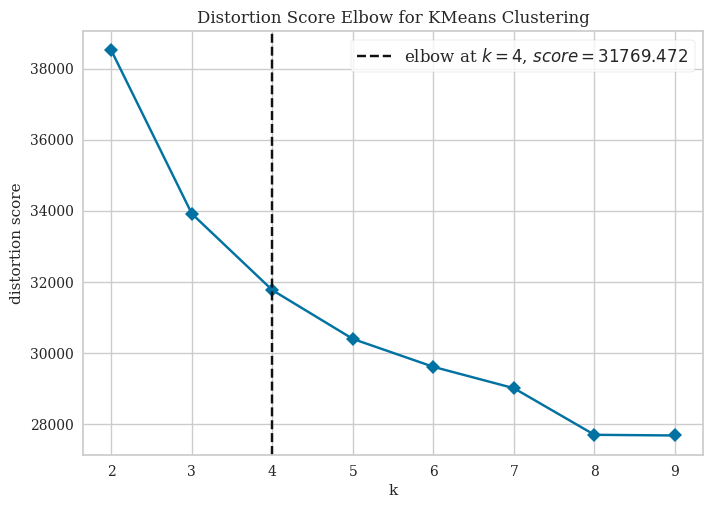

In [11]:
kmeans = KMeans()

visualizer = KElbowVisualizer(kmeans, k=(2,10), timings=False)

visualizer.fit(X_train_processed)
visualizer.show();

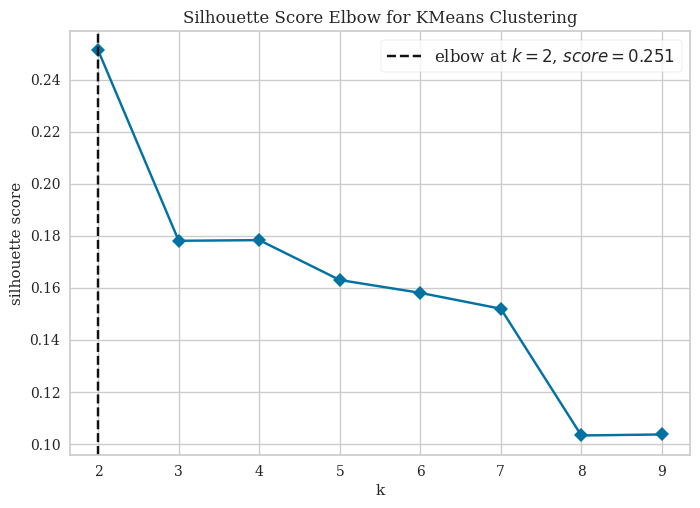

In [12]:
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings=False, metric = "silhouette")

visualizer.fit(X_train_processed)
visualizer.show();

Como para o método de silhueta o número ideal de clusters foi 2, pela simplicidade, utilizaremos apenas 2 clusters

In [13]:
# Criando espaço de redução de dimensionalidade via PCA
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(X_train_processed)


In [14]:
X_train_processed.shape

(5625, 45)

In [15]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(X_train_processed)

X_train["cluster"] = kmeans.labels_

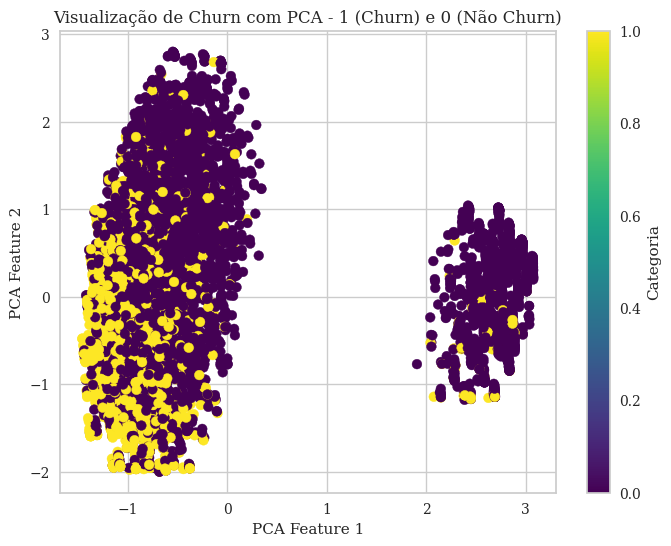

In [16]:
# Visualizando se há alguma diferença nos clusters se comparado com os churns


plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=y_train.astype("category").cat.codes, cmap='viridis')
plt.colorbar(label='Categoria')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Visualização de Churn com PCA - 1 (Churn) e 0 (Não Churn)')
plt.show()


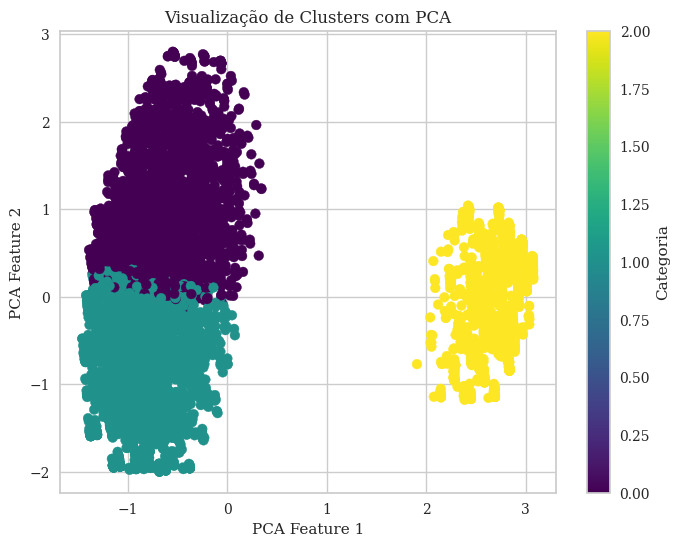

In [17]:
# Visualizando a separação via clusters.
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=X_train["cluster"].astype("category").cat.codes, cmap='viridis')
plt.colorbar(label='Categoria')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Visualização de Clusters com PCA')
plt.show()


Repara-se que há uma grande predominância de não ocorrência de churn no cluster da direita, o que pode ser um grande indicador de não ocorrência de churn futura, para a esquerda ainda está difuso, porém definitivamente é uma feature que vale a pena ser mantida.

Vou utilizar um algoritmo de árvore para tentar discernir qual o tipo de perfil que se encaixa em um cluster ou outro pra adquirir mais informações sobre os clusters:

In [18]:
dt = DecisionTreeClassifier(max_depth=2, random_state=42)
dt.fit(X_train_processed, X_train["cluster"])

DecisionTreeClassifier(max_depth=2, random_state=42)

In [19]:
X_train_processed.shape

(5625, 45)

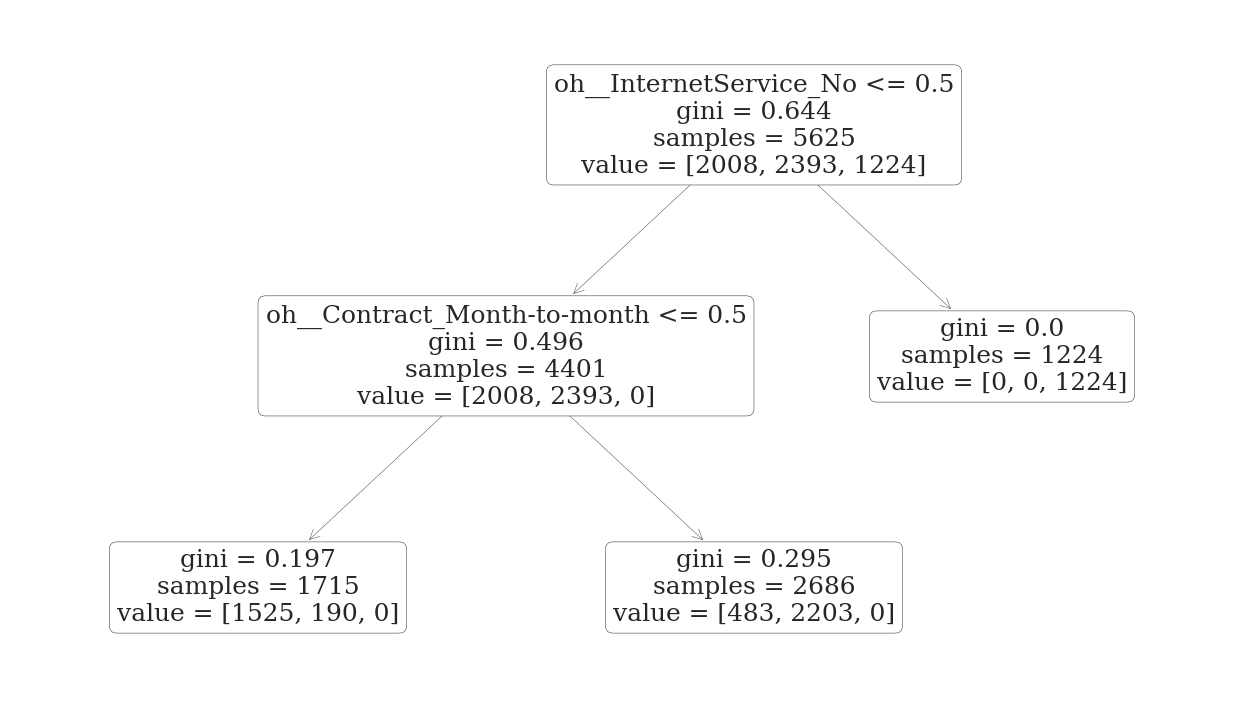

In [20]:
columns = feature_names
plt.figure(figsize=(16,9))
plot_tree(dt, feature_names=columns, rounded=True);

In [22]:
accuracy_score(X_train["cluster"], dt.predict(X_train_processed))

0.8803555555555556

Aqui dá pra perceber que há uma diferença notória entre quem tem serviços de internet ou não, eu não tinha percebido na EDA, mas aqueles que não possuem serviços de internet (e consequentemente serviços relacionados como streaming, assistência técnica, segurança de internet etc) tem uma porcentagem de churn muito baixa, o que pode indicar que o churn pode estar diretamente ligado ao serviço de internet.

Além disso, no cluster 1 e 2, que estão mais juntos pelo kmeans, há diferenças envolvendo TotalCharges e MonthlyCharges, isso pode ser reflexo da situação sócioeconômica do consumidor, como alto preço de serviço comparado a competidores etc. Isso, poderá nos levar a 3 categorias de usuários, aqueles que não possuem internet, e aqueles que possuem, mas podem ser diferenciados pelo método de pagamento (mensal, anual etc). Daqui vamos criar 3 grupos de indivíduos, as pessoas com internet, as pessoas que possuem internet mas pagam serviço mensal e as que possuem internet que não pagam serviço mensal. 

Em questão de modelagem, esses clusters estão inseridos dentro de outras categorias, mas vou manter a coluna porque ainda sim pode acabar sendo relevante pros modelos. Em insights de negócio, mais uma vez, vale a pena voltar os olhos pra esses 3 públicos em específico e talvez gerar uma maior customização ou personalização de serviços pra eles.

# Criando categoria para todos os dados e salvando os dados

In [23]:
customer_churn["custom_cluster"] = kmeans.predict(ct.transform(X))

In [25]:
customer_churn["custom_cluster"].value_counts()

custom_cluster
1    3008
0    2504
2    1520
Name: count, dtype: int64

In [27]:
customer_churn.to_csv("../data/final/customer_churn.csv", index=False)